## Spherical Splines based on Jupp & Kent (1987)



In [1]:
import pandas as pd
import numpy as np
import os
import cartopy.crs as ccrs
import pmagpy.ipmag as ipmag

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 20)

from utils.geometry import cartesian2spherical, spherical2cartesian

In [2]:
df = pd.read_csv('data/Jupp-etal-1987_dataset.csv', encoding="cp1254")

# In order to do splines, we need the time coordinate to be strictly increasing. This is a little bit annoying, so for now
# I will add a small noise to the time column so to ignore this.
df.Time += 0.01 * np.random.uniform(-1,1,df.shape[0])

# We also manually add a fixed point in the origin of coordinates 
df.loc[df.shape[0]] = ['Origin', 0, 90., 0]

# Add cartesian coordinates
df['x'] = df.apply(lambda row: spherical2cartesian([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
df['y'] = df.apply(lambda row: spherical2cartesian([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
df['z'] = df.apply(lambda row: spherical2cartesian([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

df = df.sort_values(by='Time')
df

,ï»¿Obs,Time,Lat,Lon,x,y,z
26,Origin,0.000000,90.0,0.0,6.123234e-17,0.000000,1.000000
0,A,0.300501,80.6,349.2,1.604330e-01,-0.030604,0.986572
1,B,0.990643,86.2,123.7,-3.677170e-02,0.055137,0.997801
2,C,1.008337,86.6,205.5,-5.352906e-02,-0.025532,0.998240
3,D,14.900521,83.3,294.0,4.745426e-02,-0.106584,0.993171
4,E,26.591169,84.8,67.6,3.453739e-02,0.083794,0.995884
5,F,32.499092,81.0,41.0,1.180626e-01,0.102630,0.987688
6,G,55.490848,86.0,178.0,-6.971398e-02,0.002434,0.997564
7,H,68.906150,76.0,147.0,-2.028928e-01,0.131760,0.970296
8,I,98.009586,86.0,298.0,3.274868e-02,-0.061591,0.997564


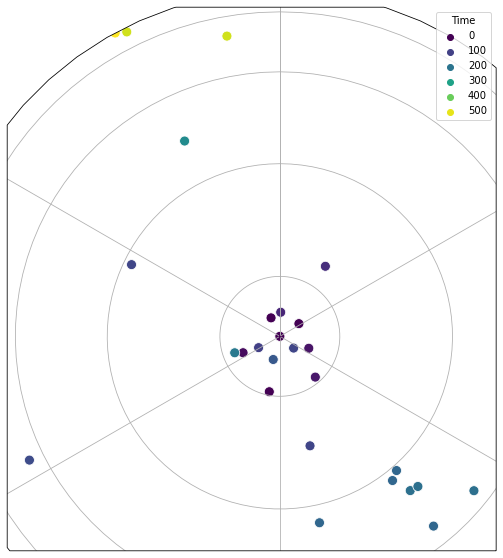

In [3]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

#ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

## Setup



In [4]:
from typing import NamedTuple

class Params(NamedTuple):
    
    lamb : float    
    delta : float 
    
params = Params(lamb = 4*10e4,
                delta = .1)

In [5]:
def slerp_interpolation(p1, p2, t, order, tmin=None, tmax=None):
    '''
    Returns the Slerp interpolation between two unitary vectors on the 3D sphere following a great circle
    '''
    angle = np.arccos(np.dot(p1,p2))
    
    if order == 0:
        return ( np.sin((1-t)*angle) * p1 + np.sin(t*angle) * p2 ) / np.sin(angle)
    elif order == 1:
        return angle * ( np.cos(t*angle) * p2 - np.cos((1-t)*angle) * p1 ) / (np.sin(angle) * (tmax-tmin)) 
    else:
        raise ValueError('Order derivative not implemented.')
        
        
def cart2sph(X, radians=True):
    '''
    X : (N,3) numpy array
    '''
    Y = np.zeros((X.shape[0], 2))
    Y[:,0] = np.arctan2(X[:,1], X[:,0])  # Longitude
    Y[:,1] = np.arcsin(X[:,2])          # Latitude
    #Y[:,1] = np.arccos(X[:,2])           # Colatitude

    if not radians:
        Y *= 180. / np.pi
    
    return Y

In [6]:
class S2Curve:
    '''
    Curve clase we are going to fit in the sphere.
    This will be consist in a series of timesteps where we can exactly evaluate the curve. For all the intermediate steps, we use the 
    great circle between adjacent knots to evalaute the function 
    '''
    
    def __init__(self, time_values, knot_values):
        
        self.time_values = time_values
        self.knot_values = knot_values
        self.planar_values = None
        self.Rotations = None
    
    #time_values : np.ndarray   # (N,) 
    #knot_values : np.ndarray   # (N,3) 
    #planar_values : np.ndarray # (N,2) 
    #Rotations : np.ndarray     # (N,3,3)
    
    def evaluate(self, t, order=0):
        """
        Return evaluation of the curve
        
        Parameters:
        - order: order correspondint to the evaluation of the derivative. If equals to 0 this is just the evaluation of the function. 
        
        """
            
        assert (np.min(self.time_values) <= t) & (t <= np.max(self.time_values)), 'Age value is not inside the evaluation window.'
        
        idx_inf = np.max(np.where(self.time_values - t <= 0.0))
        idx_sup = np.min(np.where(self.time_values - t > 0.0))
        if idx_inf == idx_sup: 
            return self.knot_values[idx_inf, :]
            print('Evaluating self node.')
        assert idx_inf + 1 == idx_sup
        
        time_inf = self.time_values[idx_inf]
        time_sup = self.time_values[idx_sup]
        incremental = (t - time_inf) / (time_sup - time_inf)
        assert 0 <= incremental <= 1
        
        knot_inf = self.knot_values[idx_inf, :]
        knot_sup = self.knot_values[idx_sup, :]
                            
        return slerp_interpolation(knot_inf, knot_sup, incremental, order=order, tmin=time_inf, tmax=time_sup)

    def update_rotation(self, R):
        self.Rotations = R
        
    def update_unroll(self, unrolled):
        self.planar_values = unrolled
    
    def plot(self):
        plt.figure(figsize=(15,8))
        ax1 = plt.subplot2grid((2,2), (0,0), rowspan=2, projection=ccrs.Orthographic(central_latitude=90))
        ax2 = plt.subplot2grid((2,2), (0,1))
        ax3 = plt.subplot2grid((2,2), (1,1))
        
        ax1.gridlines()
        
        knot_values_sph = cart2sph(self.knot_values, radians=False) 
        
        sns.scatterplot(ax=ax1, x = knot_values_sph[:,0], y = knot_values_sph[:,1], 
                        hue = self.time_values,
                        transform = ccrs.PlateCarree())
        
        ax2.plot(self.time_values,  knot_values_sph[:,0], 'o-')
        ax3.plot(self.time_values,  knot_values_sph[:,1], 'o-')

In [7]:
# We first define a curve with the values we have in the dataset
curve_original = S2Curve(time_values=df.Time.values,
                         knot_values=df[['x', 'y', 'z']].values)
                         #Rotations=None,
                         #planar_values=None)

# and then we use it to construct a more finer curve
#time_steps = np.unique(np.sort(np.concatenate([np.arange(0, df.Time.max(), params.delta), df.Time.values])))
time_steps = np.arange(0.0, df.Time.max()-1, params.delta)
knot_steps = np.array([curve_original.evaluate(t,0) for t in time_steps])

curve = S2Curve(time_values=time_steps,
                knot_values=knot_steps)
                #Rotations=None,
                #planar_values=None)

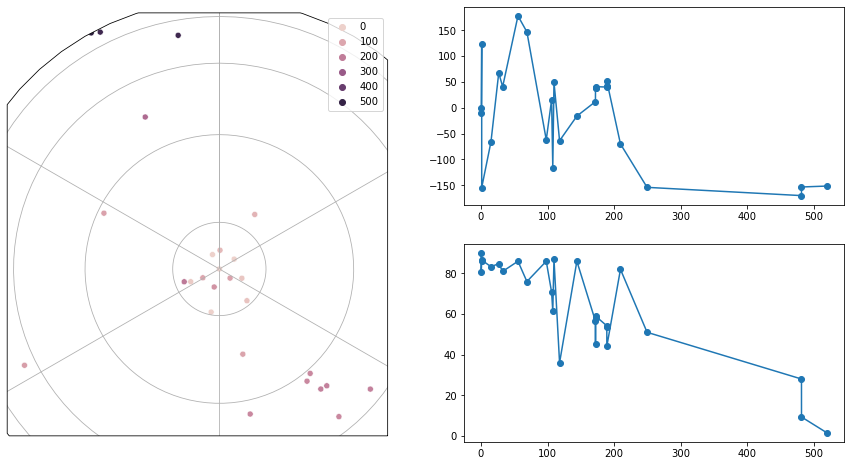

In [8]:
curve_original.plot()

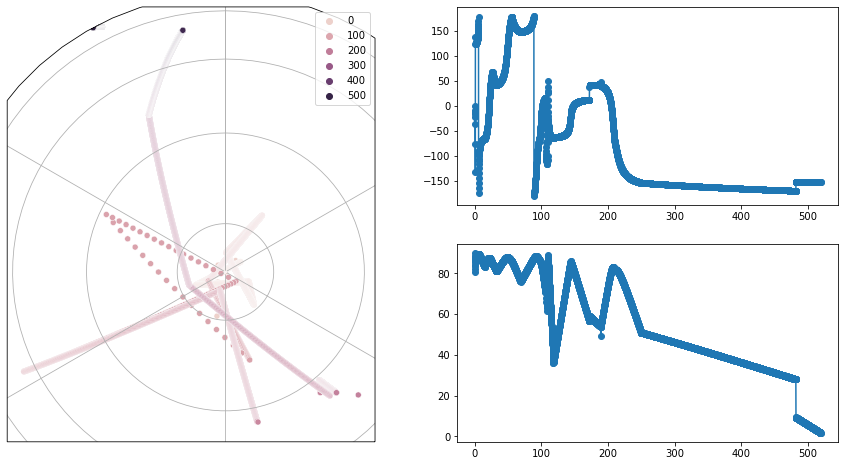

In [13]:
curve.plot()

## Unrolling the curve

Unrolling the curve $f: [0, T] \mapsto S^2$ requires to solve a set of differntial equation for both $f(t)$ and the rotation matrix $R(t)$, defined as 
$$
R(t)f(t) = (0,0,1).
$$
The differential equations are
$$
\frac{d}{dt}f^*(t) = R(t) f(t)
$$
and 
$$
R(t)^T R'(t) = M( f'(t) \times f(t))
$$
with initial conditions 
$$
f^*(0) = 0 \qquad R(0)f'(0) = (\| f'(0) \|,0,0)
$$

In [9]:
from scipy.spatial.transform import Rotation as Rotation_operator

def skew_matrix(v):
    skv = np.roll(np.roll(np.diag(v.flatten()), 1, 1), -1, 0)
    return skv - skv.T

def unroll_curve(curve, n_steps=10):
    '''
    Unroll one single curve f to f* following the Appendix in Jupp et. al. (1987)
    
    Given a Curve() object, we return the 
    '''    
    N = curve.time_values.shape[0]
    
    f_star = np.zeros((N,3))    # We leave the third coordinate always equal to zero for simplicity
    Rotation = np.zeros((N,3,3))
    
    # Initial conditions
    # To define the Initial rotation matrix, we need to compute the axis of rotation given by the cross product of the vectors and
    # rotate in a quantity equals to the geodesic distance between points
    derivative_normalized = curve.evaluate(0,order=1) 
    derivative_normalized /= np.linalg.norm(derivative_normalized)
    print(derivative_normalized)
    angle = np.arccos(np.dot(derivative_normalized, [1,0,0]))
    rotation_axis = np.cross(derivative_normalized, [1,0,0])
    rotation_axis /= np.linalg.norm(rotation_axis)
    R = Rotation_operator.from_rotvec(angle * rotation_axis)
    assert np.arccos(np.dot(R.apply(derivative_normalized), [1,0,0])) < 0.01, 'The obtained initial rotation R(0) does not satisfy R(0)df(0)=[c,0,0]'
    
    f_star[0,:] = [0,0,0]
    Rotation[0,:,:] = R.as_matrix()
    
    # Iterative steps
    delta_t = np.diff(curve.time_values)
    
    for idx, dt in enumerate(delta_t): 
        
        t = curve.time_values[idx]        
        dtt = dt / n_steps
        
        f_ = f_star[idx,:]
        R = Rotation[idx,:,:]
        
        for _ in range(n_steps):
        
            f = curve.evaluate(t, order=0)
            df = curve.evaluate(t, order=1)
            f_ += dtt * np.dot(R, df)
            R += dtt * np.dot(R, skew_matrix(np.cross(df,f)))
            t += dtt
        
        f_star[idx+1,:] = f_ 
        assert np.abs(f_star[idx+1,2]) < 0.01, 'Reduce the solver time step to ensure the solution is correct.'
        Rotation[idx+1,:,:] = R
    

    return curve.time_values, f_star, Rotation

In [10]:
time, f_star, Rotation = unroll_curve(curve)

[ 9.822872507286885e-01 -1.873813145857248e-01 -2.034542850320661e-15]


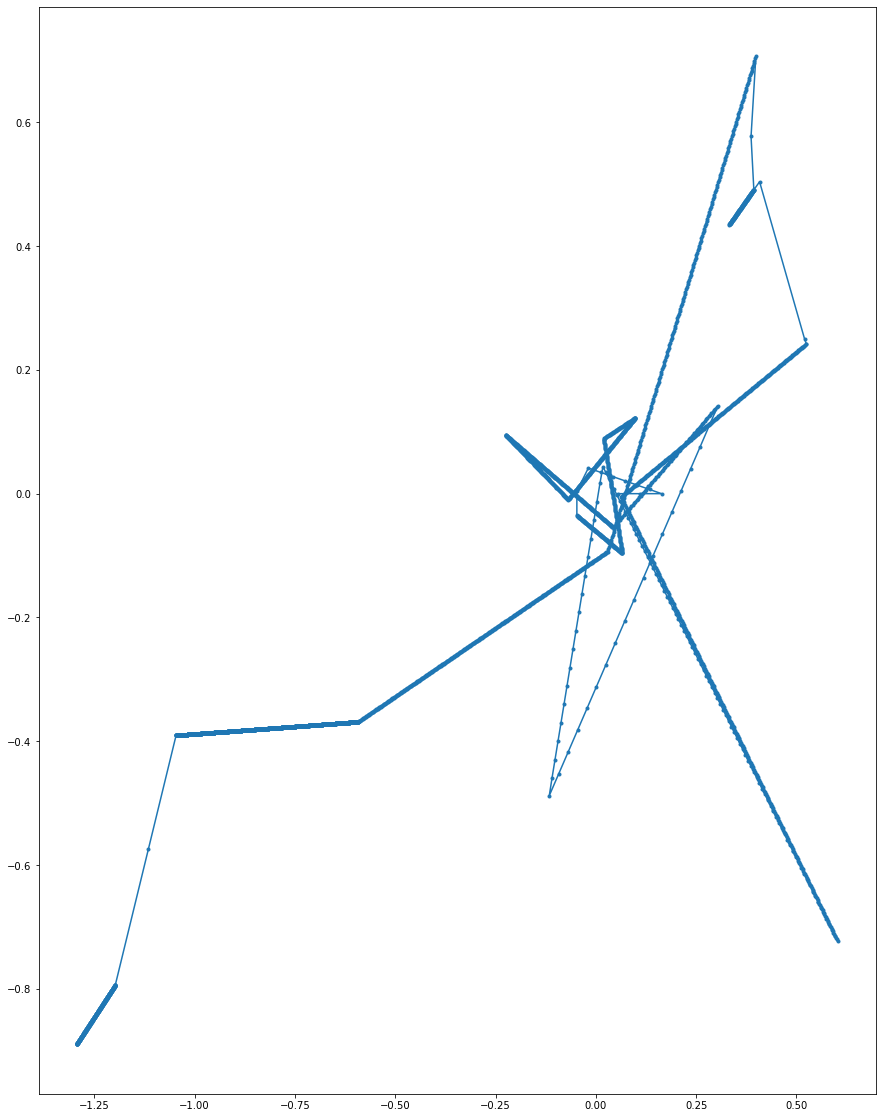

In [11]:
plt.plot(f_star[:,0], f_star[:,1], '.-')

Now we can define how to roll a curve into the sphere.

In [12]:
def roll_curve(times, X, n_steps=10):
    '''
    Arguments:
        - time: (N,) 
        - X: (N, 3) numpy array
    '''
    
    N = X.shape[0]
    
    F = np.zeros((N,3))   
    Rotation = np.zeros((N,3,3))
    
    # initial conditions
    F[0,:] = [0,0,1]   # The initial potition of the rolling can be chosen arbitratrarialy
    df = [1,0,0] 
    Rotation[0,:,:] = np.eye(3)
    
    # We compute the derivative of f*
    Df_star = np.diff(X, axis=0) / np.diff(time)[:, np.newaxis]

    delta_t = np.diff(times)
    
    for idx, dt in enumerate(delta_t):
        
        t = time[idx]
        #dtt = dt / n_steps
        
        R = Rotation[idx,:,:]
        f = F[idx,:]
        f_star = X[idx,:,]
        df_star = Df_star[idx,:]
        
        #for _ in range(n_steps):
            
        f += dt * np.dot(R.T, df_star)
        # Renormalize for numerical error
        f /= np.linalg.norm(f)
        R += dt * np.dot(skew_matrix(np.cross(df_star, [0,0,1])), R)

        #t += dtt
    
        F[idx+1,:] = f
        Rotation[idx+1,:,:] = R
    
    return  S2Curve(time_values=times,
                    knot_values=F)

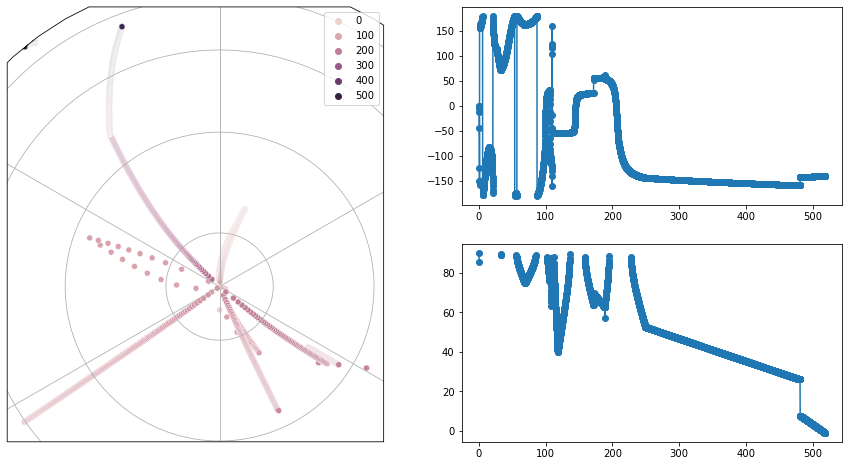

In [18]:
roll_curve(time, f_star).plot()

Now we need to unroll individual points to the plane and viceversa,

In [13]:
def equal_distance_projection(X):
    
    Y = cart2sph(X, radians=True)
    Z = np.zeros(X.shape)
    
    # I need the colatitude for the projection 
        
    Z[:,0] = (np.pi/2-Y[:,1]) * np.cos(Y[:,0])
    Z[:,1] = (np.pi/2-Y[:,1]) * np.sin(Y[:,0])
    
    return Z

def unroll_points(curve, point_times, D):
    '''
    We unroll the points D using a given curve.
    
    Arguments:
        - curve: Curve() object
        - D: (M,3)
        - point_times: (M,)
    '''
    
    D_star = np.zeros(D.shape)
    
    for idx, t in enumerate(point_times):
        # First we identify the right time 
        idx_inf = np.max(np.where(curve.time_values - t <= 0.0))
        # Evaluate rotation there 
        R = curve.Rotations[idx_inf,:,:]
        # Apply rotation to point
        d_rotated = np.dot(R, D[idx,:])
        # Since we have numerical errors, we need to renormalize the vectors on the sphere
        d_rotated /= np.linalg.norm(d_rotated)
        d_rotated = d_rotated[np.newaxis,:]
        # equal distance projection
        d_projected = equal_distance_projection(d_rotated)
        D_star[idx,:] = curve.planar_values[idx,:] + d_projected
        
    return D_star

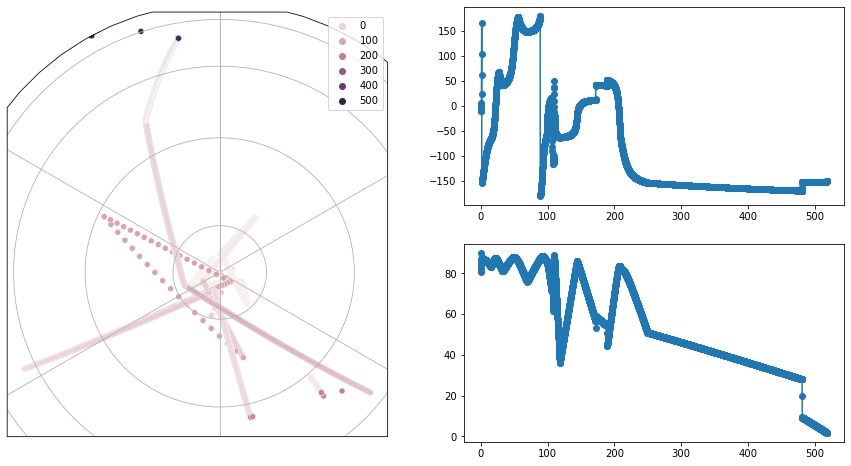

In [44]:
# We first define a curve with the values we have in the dataset
curve_original = S2Curve(time_values=df.Time.values,
                         knot_values=df[['x', 'y', 'z']].values)

# and then we use it to construct a more finer curve
#time_steps = np.unique(np.sort(np.concatenate([np.arange(0, df.Time.max(), params.delta), df.Time.values])))
time_steps = np.arange(0.0, df.Time.max()-1, params.delta)
knot_steps = np.array([curve_original.evaluate(t,0) for t in time_steps])

curve = S2Curve(time_values=time_steps,
                knot_values=knot_steps)

curve.plot()

In [ ]:
n_iter = 3

for _ in range(n_iter):

    print(_)
    
    ### Unroll curve ###
    curve.plot()
    time, f_star, Rotation = unroll_curve(curve, n_steps=200)
    
    # Update rotation and f* from unrolling
    curve.update_rotation(Rotation)
    curve.update_unroll(f_star)
    
    ### Unroll points ###
    D_star = unroll_points(curve, df.Time.values, df[['x','y','z']].values)
    
    ### Fit Splines ###
    
    #spl_x = UnivariateSpline(df.Time.values, D_star[:,0], k=3)
    spl_x = UnivariateSpline(df.Time.values, D_star[:,0], k=1, s=0)
    #spl_x.set_smoothing_factor(0.05)

    spl_y = UnivariateSpline(df.Time.values, D_star[:,1], k=1, s=0)
    #spl_y = UnivariateSpline(df.Time.values, D_star[:,1], k=3)
    #spl_y.set_smoothing_factor(0.05)
    
    X_ = spl_x(curve.time_values)
    Y_ = spl_y(curve.time_values)
    
    ### Update curve ###
    curve = roll_curve(curve.time_values, np.array([X_, Y_, np.ones(X_.shape[0])]).T)

    
curve.plot()

0
[ 9.822872507286885e-01 -1.873813145857248e-01 -2.034542850320661e-15]
1
[ 0.997713243588255 -0.049109760651024 -0.046438292145632]


In [ ]:
# Fix the fact that the rotation is not updated as a rotation!!!

In [ ]:
time, f_star, Rotation = unroll_curve(curve)

In [23]:
curve.time_values

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 5.184e+02, 5.185e+02,
       5.186e+02])

In [24]:
curve.knot_values

array([[-2.256501511785636e-04, -8.749720221270380e-06,
         1.000000000000000e+00],
       [-4.510889038186333e-04, -1.741362020717986e-05,
         9.999999490539047e-01],
       [-6.763163242121952e-04, -2.599174116361379e-05,
         9.999998473069331e-01],
       ...,
       [-1.328759564061848e-01,  1.403989970546293e-01,
         9.811658247326542e-01],
       [-1.330511654435109e-01,  1.402763445097613e-01,
         9.811596480119701e-01],
       [-1.330511654435109e-01,  1.402763445097613e-01,
         9.811596480119701e-01]])

In [25]:
curve.evaluate(10)

array([nan, nan, nan])

In [30]:
my_t = 10
idx_inf = np.max(np.where(curve.time_values - my_t <= 0.0))
idx_sup = np.min(np.where(curve.time_values - my_t > 0.0))
idx_inf, idx_sup

time_inf = curve.time_values[idx_inf]
time_sup = curve.time_values[idx_sup]
incremental = (my_t - time_inf) / (time_sup - time_inf)
time_inf, time_sup, incremental

(10.0, 10.100000000000001, 0.0)

In [32]:
knot_inf = curve.knot_values[idx_inf, :]
knot_sup = curve.knot_values[idx_sup, :]
knot_inf, knot_sup

(array([-2.173440094770197e-02, -4.572202098965463e-04,
         9.997660180926513e-01]),
 array([-2.193904469191293e-02, -4.575111155902102e-04,
         9.997615691094699e-01]))

In [34]:
slerp_interpolation(knot_inf, knot_sup, incremental, order=0, tmin=time_inf, tmax=time_sup)

array([nan, nan, nan])

In [36]:
p1 = knot_inf, 
p2 = knot_sup

angle = np.arccos(np.dot(p1,p2))
    
( np.sin((1-incremental)*angle) * p1 + np.sin(incremental*angle) * p2 ) / np.sin(angle)

array([[nan, nan, nan]])

In [38]:
np.dot(p1,p2)

array([1.000004684167708])

In [ ]:
        assert (np.min(self.time_values) <= t) & (t <= np.max(self.time_values)), 'Age value is not inside the evaluation window.'
        
        idx_inf = np.max(np.where(self.time_values - t <= 0.0))
        idx_sup = np.min(np.where(self.time_values - t > 0.0))
        if idx_inf == idx_sup: 
            return self.knot_values[idx_inf, :]
            print('Evaluating self node.')
        assert idx_inf + 1 == idx_sup
        
        time_inf = self.time_values[idx_inf]
        time_sup = self.time_values[idx_sup]
        incremental = (t - time_inf) / (time_sup - time_inf)
        assert 0 <= incremental <= 1
        
        knot_inf = self.knot_values[idx_inf, :]
        knot_sup = self.knot_values[idx_sup, :]
                            
        return slerp_interpolation(knot_inf, knot_sup, incremental, order=order, tmin=time_inf, tmax=time_sup)

In [181]:
curve.update_rotation(Rotation)
curve.update_unroll(f_star)

In [185]:
D_star = unroll_points(curve, df.Time.values, df[['x','y','z']].values)

In [213]:
from scipy.interpolate import UnivariateSpline

spl_x = UnivariateSpline(df.Time.values, D_star[:,0], k=3)
spl_x.set_smoothing_factor(0.5)

spl_y = UnivariateSpline(df.Time.values, D_star[:,1], k=3)
spl_y.set_smoothing_factor(0.5)

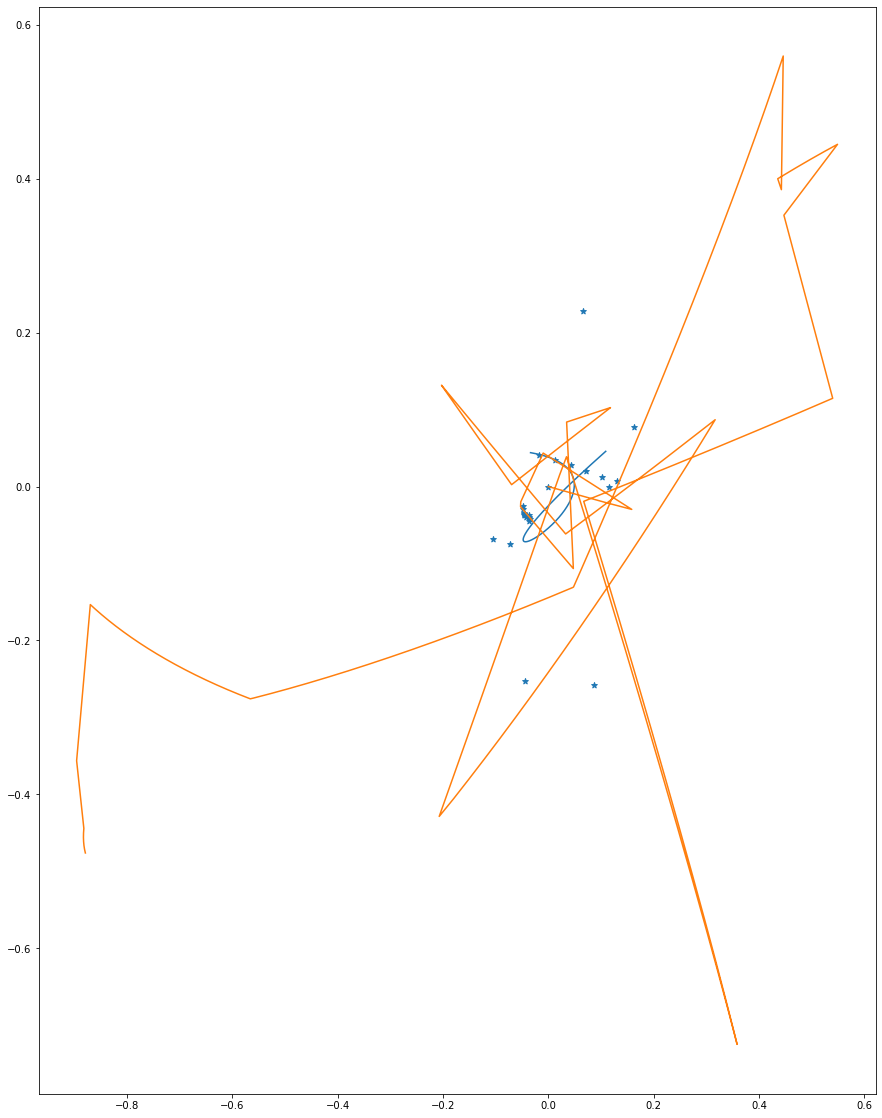

In [214]:
X_ = spl_x(curve.time_values)
Y_ = spl_y(curve.time_values)

plt.plot(X_, Y_, '-')
plt.plot(curve.knot_values[:,0], curve.knot_values[:,1])
plt.scatter(D_star[:,0], D_star[:,1], marker='*')

In [231]:
new_curve = roll_curve(curve.time_values, np.array([X_, Y_, np.ones(X_.shape[0])]).T)

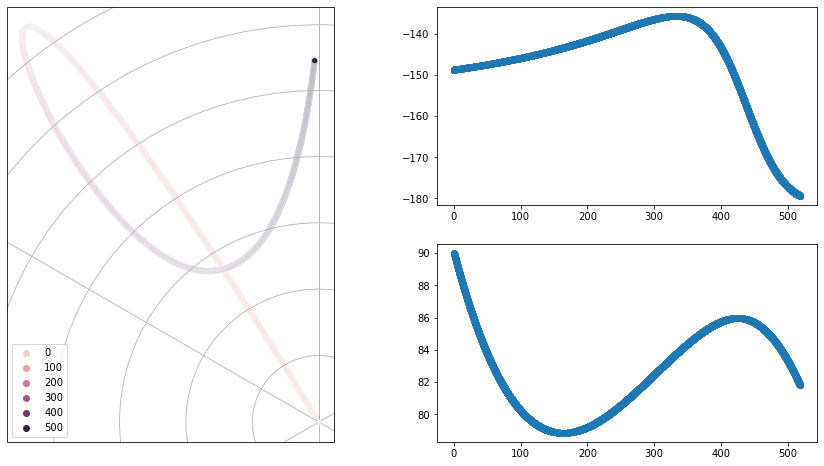

In [232]:
new_curve.plot()

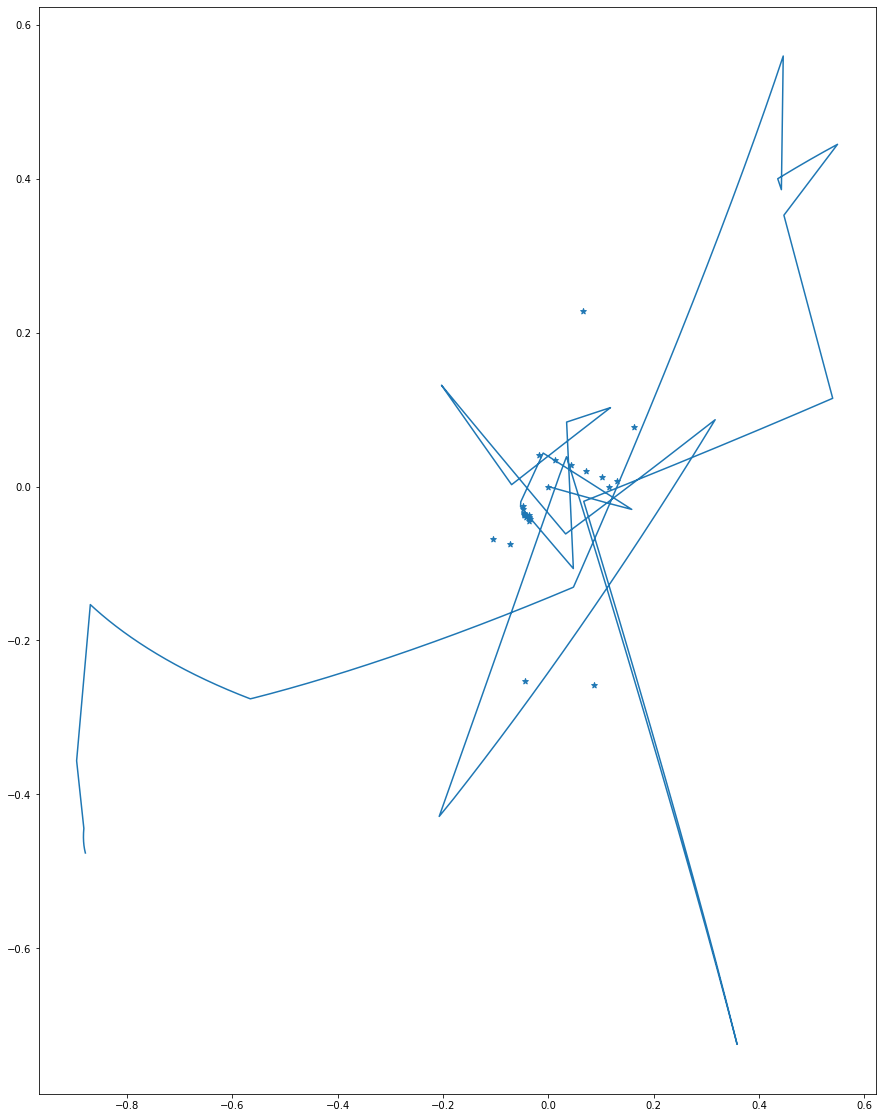

In [183]:
#curve.plot()
